<p style="font-weight: bold;text-align: center;font-size: 2em;color: #00338D">Herschel PACS IFU Data Visualization and Analysis</p>

**Authors:** Elena Puga, Henrik Norman
**Creation:** 05.08.2020

## Context
This notebook is a worked example on how to download, manipulate and perform a basic analysis on [__Herschel PACS__](https://www.cosmos.esa.int/web/herschel/legacy-documentation-pacs) data cubes, as the PACS instrument was the first Integral Field Unit on space.
The original analysis capabilities were a functionality provided by the Herschel Interactive Pipeline Environment (HIPE), which had the Spectrum explorer and contained dedicated toolboxes like: a) Spectrum Toolbox, b) SpectrumFitterGUI, and c) the Cube Toolbox.

New Python manipulation (`specutils`, `spectral-cube`) and visualization tools (`SpecViz`, `CubeViz`) have been developed in the context of future observatories ([__JWST__](https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis#JWSTPost-PipelineDataAnalysis-JWSTJupyterNotebooks), Roman ST), and in this notebook we showcase the usability of these tools with existing calibrated and consolidated ESA data products. 

## Science case

Observation of the bipolar nebula IRAS 19312+1950 from the OT2_mcordine_2 program that exhibits both features of a massive oxigen-rich AGB star, and a young stellar object ([Cordiner et al. 2016](https://ui.adsabs.harvard.edu/#abs/2016ApJ...828...51C)). 

**Note:** These are the only chopNod SED oversampled raster observations that PACS performed during its mission, displaying a plethora of spectral features, mostly CO, H$_2$O, OH and O lines 
***

## Notebook Structure
- [Data access](#data_access)
- [Data manipulation and launching of visualization tool](#data_manipulation)
- [Data analysis](#data_analysis):
    1. Create 'sci' spectral cube, check dimensions  
    2. Create a Boolean Mask from the 'sci' finite data
    3. Extract the object 1D spectrum of the central spaxel and cast it in specutils.spectra.Spectrum1D
    4. 1D Model fitting:
       1. Examine with Spectrum Viewer User Interface, select spectral range and test the line+continuum model fit
       2. Automated cluster line + local continuum fit class
    5. Extraction of cube spectral slab
    6. Cube fitting (pixel-by-pixel) using the backend of the app model fitting plugin
    7. Continuum model evaluation and subtraction

In [1]:
from IPython.display import Image
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import requests
import shutil

In [2]:
from astropy.io import fits
from astropy import units as u
from astropy.nddata import StdDevUncertainty
import astropy.modeling.models as models
from astropy.table import Table
from astroquery.esasky import ESASky
from astropy.wcs import WCS
from jdaviz.app import Application
from jdaviz import SpecViz as spcv
from spectral_cube import SpectralCube, LazyMask
from specutils.fitting import fit_lines
from specutils.spectra import Spectrum1D, SpectralRegion
from specutils.manipulation import extract_region

from utils import LineFitterMult, fit_model_to_spectrum

Created TAP+ (v20200428.1) - Connection:
	Host: sky.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


ModuleNotFoundError: No module named 'jdaviz'

<a id="data_access"></a>
## Data Identification and Access 
We make use of [`astroquery.esasky`](https://astroquery.readthedocs.io/en/latest/esasky/esasky.html), the python interface for querying the [ESASky](https://www.cosmos.esa.int/web/esdc/esasky-help) web service. This module allows querying an object as well as querying a region around the target. Its latest development supports the query and download of spectral data.
Alternatively, we may retrieve the cube using the `TapPlus` in [astroquery.utils.tap](https://astroquery.readthedocs.io/en/latest/utils/tap.html)

In [3]:
# Available missions with spectra in ESASky
spectra_list = ESASky.list_spectra()
print(spectra_list)

['XMM-NEWTON', 'Chandra', 'IUE', 'HST-UV', 'HST-OPTICAL', 'HST-IR', 'ISO-IR', 'Herschel', 'LAMOST']


In [4]:
# Search Herschel mission spectroscopic observations for our target
target_name = 'IRAS 19312+1950'
radius = '1arcmin'
result = ESASky.query_region_spectra(position=target_name, radius=radius, missions=['HERSCHEL'])

# Print table data model
print(result['HERSCHEL'].info)

<Table length=12>
        name         dtype    unit                         description                       
------------------- ------- ------- ---------------------------------------------------------
       postcard_url  object                          The URL to download the postcard preview
        product_url  object                                   The URL to download the product
     observation_id  object                          The identifier of a Herschel observation
             ra_deg float64     deg                        Actual right ascension of pointing
            dec_deg float64     deg                            Actual declination of pointing
        target_name  object                                            The name of the target
         instrument  object                                           The Herschel instrument
observing_mode_name  object                               Name of the Herschel observing mode
               band  object         Freque

In [5]:
# This is the list of observations
result['HERSCHEL']['observation_id', 'target_name', 'instrument', 'observing_mode_name', 'band', 'duration'].pprint_all()

observation_id   target_name   instrument observing_mode_name         band        duration
                                                                                  seconds 
-------------- --------------- ---------- ------------------- ------------------- --------
    1342245380 IRAS 19312+1950       HIFI    HifiPointModeDBS   543.78-559.90 GHz  758.028
    1342245378 IRAS 19312+1950       HIFI    HifiPointModeDBS 1094.85-1110.97 GHz 2028.414
    1342255789 IRAS 19312+1950       HIFI    HifiPointModeDBS   606.39-622.52 GHz  739.043
    1342245227 IRAS 19312+1950       PACS        PacsLineSpec 53.74-110.25 micron   1869.0
    1342245230 IRAS 19312+1950       PACS       PacsRangeSpec 50.65-146.52 micron   4616.0
    1342252110 IRAS 19312+1950       HIFI    HifiPointModeDBS   645.33-661.45 GHz 2448.249
    1342252111 IRAS 19312+1950       HIFI    HifiPointModeDBS   677.29-693.42 GHz 1548.428
    1342255788 IRAS 19312+1950       HIFI    HifiPointModeDBS   574.26-590.38 GHz  894.281

In [6]:
obs_by_sel = result['HERSCHEL']
mask = obs_by_sel['observation_id'] == '1342245229'
obs_by_sel = obs_by_sel[mask]
obs_by_sel = Table(obs_by_sel, masked=True, copy=False)
obs_by_sel['observation_id', 'target_name', 'instrument', 'observing_mode_name', 'band', 'duration'].pprint_all()

observation_id   target_name   instrument observing_mode_name         band        duration
                                                                                  seconds 
-------------- --------------- ---------- ------------------- ------------------- --------
    1342245229 IRAS 19312+1950       PACS       PacsRangeSpec 69.81-210.30 micron   9134.0


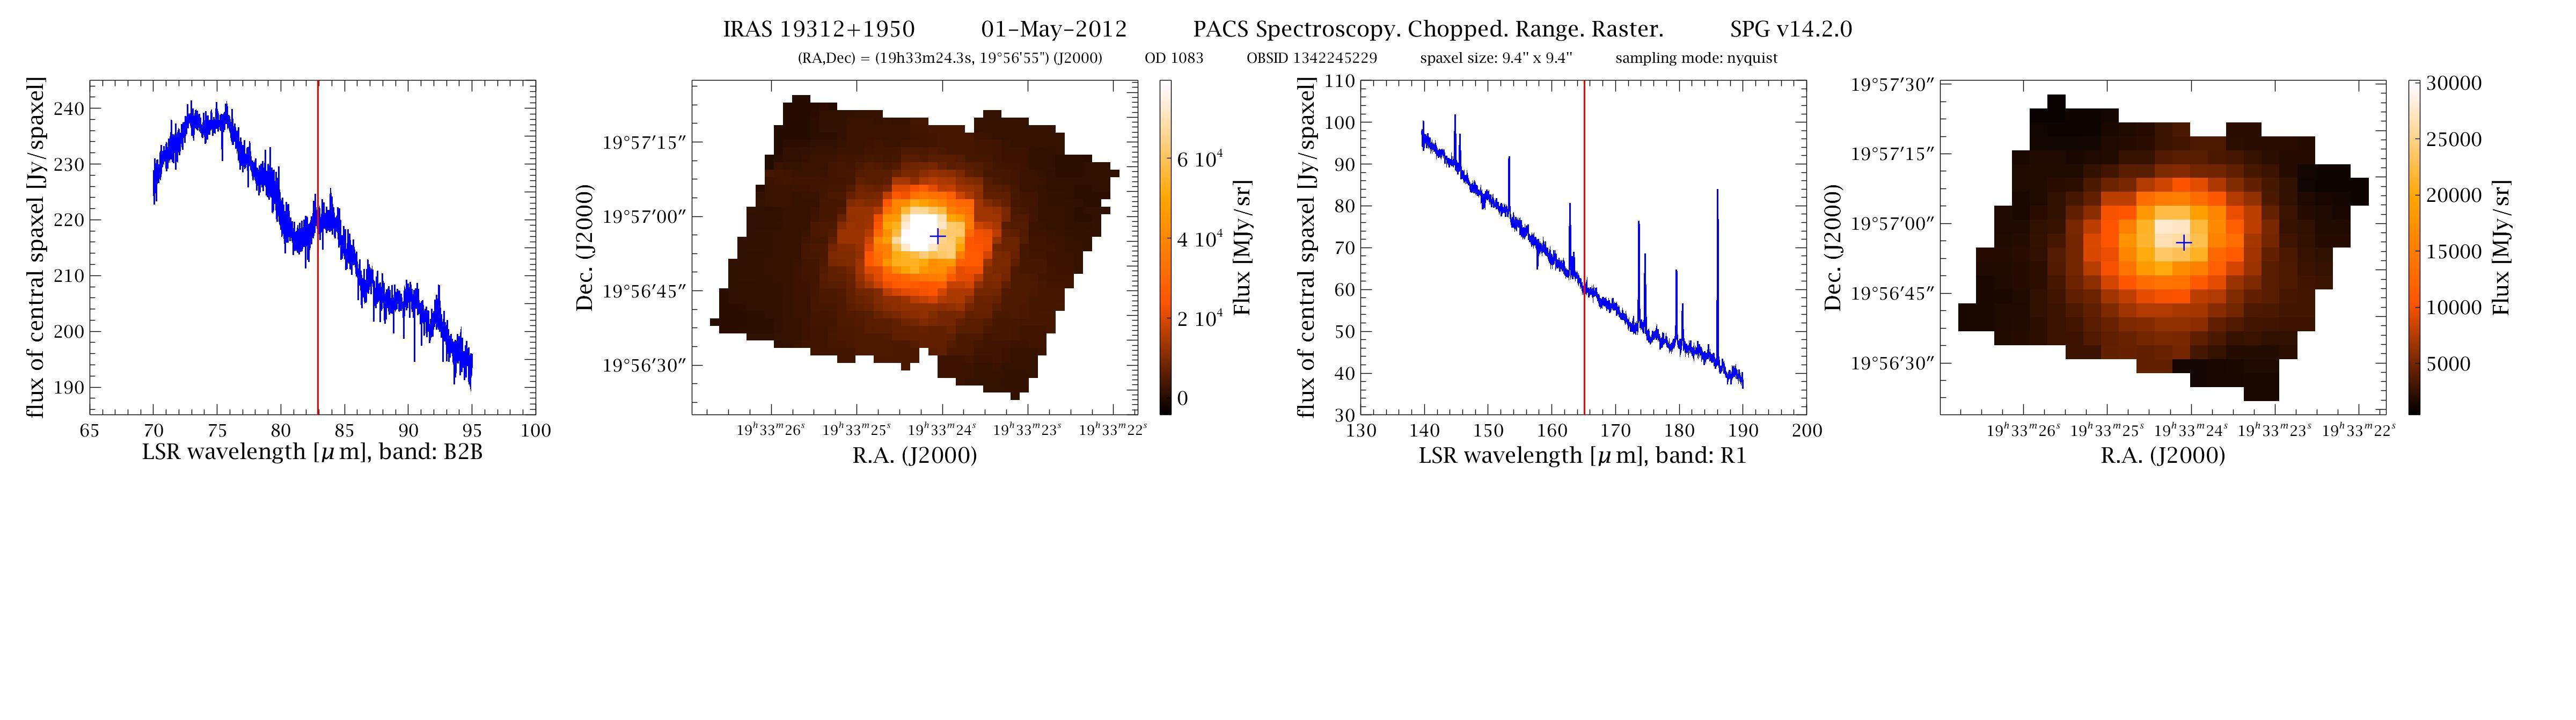

In [7]:
postcard_url = obs_by_sel['postcard_url'][0]
Image(requests.get(postcard_url).content)

### Download spectral data from Herschel Archive 

We download our _Herschel_ _PACS_ Standalone Browse Products, which are a bundle of recommended observations tailored for the specific observing mode in which they were obtained. Our `astroquery.esasky` function sorts them out by band, but we also organize them by product. A detailed explanation about PACS Standalone Browse Products is provided [here](http://herschel.esac.esa.int/hcss-doc-14.0/print/pacs-ppe/pacs-ppe.pdf)

In [8]:
spectra = ESASky.get_spectra_from_table(query_table_list=[('HERSCHEL', obs_by_sel)])

sabps = {}
for idx, obs in enumerate(spectra['HERSCHEL']):
    if (obs_by_sel['instrument'][idx] == 'PACS'):
        obsid = obs_by_sel['observation_id'][idx]
        print('OBSID: {}'.format(obsid))
        band = obs.keys()
        first_level = []
        for key, lst in obs.items():
            second_level = {}
            for hduList in lst:
                print('{}:'.format(hduList[0].header['TYPE']))
                hduList.info()
                second_level[hduList[0].header['TYPE']] = hduList
            first_level.append(second_level)
        sabps[obsid] = dict(zip(band, first_level))

INFO:astropy:Starting download of HERSCHEL data. (1 files)
INFO:astropy:Downloading Observation ID: 1342245229 from http://archives.esac.esa.int/hsa/whsa-tap-server/data?RETRIEVAL_TYPE=STANDALONE&observation_oid=8620309&DATA_RETRIEVAL_ORIGIN=UI


INFO: Starting download of HERSCHEL data. (1 files) [astroquery.esasky.core]
INFO: Downloading Observation ID: 1342245229 from http://archives.esac.esa.int/hsa/whsa-tap-server/data?RETRIEVAL_TYPE=STANDALONE&observation_oid=8620309&DATA_RETRIEVAL_ORIGIN=UI [astroquery.esasky.core]


INFO:astropy:[Done]
INFO:astropy:Downloading of HERSCHEL data complete.
INFO:astropy:Spectra available at /Users/epuga/ESDC/pyesasky_demo/myDemo/Spectra.


INFO: [Done] [astroquery.esasky.core]
INFO: Downloading of HERSCHEL data complete. [astroquery.esasky.core]
INFO: Spectra available at /Users/epuga/ESDC/pyesasky_demo/myDemo/Spectra. [astroquery.esasky.core]
OBSID: 1342245229
HPS3DEQIBS:
Filename: Spectra/HERSCHEL/anonymous1604664129/hpacs1342245229_20hps3deqibs_00_1469612618651.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     337   ()      
  1  image         1 ImageHDU        62   (25, 23, 8325)   float64   
  2  error         1 ImageHDU        62   (25, 23, 8325)   float64   
  3  wcs-tab       1 BinTableHDU     37   1R x 2C   [8325D, 8325J]   
  4  flag          1 ImageHDU        41   (25, 23, 8325)   int16   
  5  History       1 ImageHDU        23   ()      
  6  HistoryScript    1 BinTableHDU     39   68R x 1C   [185A]   
  7  HistoryTasks    1 BinTableHDU     46   37R x 4C   [1K, 31A, 1K, 9A]   
  8  HistoryParameters    1 BinTableHDU     74   360R x 10C   [1K, 27A, 13A, 

### Product selection

PACS has several Level 2 cubes for chopNod observations, depending on the spatial sampling in the raster maps: projected, drizzled, and interpolated. For this Nyquist sampled rastered map observation of a semi-extended source, we use the projected blue cube **HPS3DEQP[R|B]** 

In [9]:
pacs_product = 'HPS3DEQPRS'

In [10]:
obs_hduList = sabps['1342245229']['red'][pacs_product]

***

### WCS modification to comply with CubeViz cube standards

In [11]:
#modification of CTYPE3, to be compatible with standard jdaviz .fits parser
extnames = {'image': 'sci', 'error': 'err', 'flag': 'dq'} 
for ext in ['image', 'error', 'flag']:
    obs_hduList[ext].header['CTYPE3'] = 'WAVE'
    obs_hduList[ext].header['EXTNAME'] = extnames[ext]

In [12]:
obs_hduList.writeto(os.path.join(os.getcwd(), '{}_spectralCube.fits'.format(pacs_product)), overwrite=True)

<a id="data_manipulation"></a>
## JDAVIZ tool - CubeViz embedded   

In [13]:
app = Application(configuration='cubeviz')
app

Application(components={'g-viewer-tab': '<template>\n  <component :is="stack.container">\n    <g-viewer-tab\n …

In [14]:
#test 2 - PACS parsed as hdu object
#pacs_path = os.path.join(os.getcwd(), '{}_spectralCube.fits'.format(pacs_product))
pacs_path = '/Users/epuga/ESDC/pyesasky_demo/myDemo/HPS3DEQPRS_spectralCube.fits'
app.load_data(pacs_path)

***

<a id="data_analysis"></a>
## Data Analysis Workflow
1. Create 'sci' spectral cube, check dimensions  
2. Create a Boolean Mask from the 'sci' finite data
3. Extract the object 1D spectrum of the central spaxel and cast it in specutils.spectra.Spectrum1D
4. 1D Model fitting:
   1. Examine with Spectrum Viewer User Interface, select spectral range and test the line+continuum model fit
   2. Automated cluster line + local continuum fit class
5. Extraction of cube spectral slab
6. Cube fitting (pixel-by-pixel) using the backend of the app model fitting plugin
7. Continuum model evaluation and subtraction


Open the FITS file for reading

In [15]:
pacs_projected = fits.open(pacs_path)

In [16]:
#1. Create sci spectral cube with units, check dimensions
funit = u.Jy
wunit = u.um
flux = pacs_projected['sci'].data * funit
err = pacs_projected['err'].data * funit

wcs = WCS(pacs_projected['sci'])
sc = SpectralCube(data=flux, wcs=wcs)
mask = LazyMask(np.isfinite, cube=sc)
sc = sc.with_mask(mask)
sc_um = sc.with_spectral_unit(wunit)

print(wcs)
print(sc_um)
print('Note: {}'.format('cube shape convention: (n_s, n_y, n_x)'))
print('The cube has flux units of {}'.format(sc_um.unit))
print('The cube has spectral_axis units of {}'.format(sc_um.spectral_axis.unit))

WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---TAN'  'DEC--TAN'  'WAVE'  
CRVAL : 293.3620179989573  19.938972915404335  0.00013954963947469156  
CRPIX : 1.0  1.0  1.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : -0.0008333333333333  0.0008333333333333334  1.0272446775701382e-08  
NAXIS : 25  24  4915
SpectralCube with shape=(4915, 24, 25) and unit=Jy:
 n_x:     25  type_x: RA---TAN  unit_x: deg    range:   293.340740 deg:  293.362018 deg
 n_y:     24  type_y: DEC--TAN  unit_y: deg    range:    19.938972 deg:   19.958140 deg
 n_s:   4915  type_s: WAVE      unit_s: um     range:      139.550 um:     190.028 um
Note: cube shape convention: (n_s, n_y, n_x)
The cube has flux units of Jy
The cube has spectral_axis units of um


In [17]:
#3. Extract and cast object spectrum1D of central spaxel
_, ny, nx = sc_um.shape
flux_cnt = sc_um[:, ny//2, nx//2] 
err_cnt = err[:, ny//2, nx//2] 
wave = sc_um.spectral_axis
wave.unit, flux_cnt.unit

(Unit("um"), Unit("Jy"))

In [18]:
spectrum_cnt = Spectrum1D(spectral_axis=wave, flux=flux_cnt, uncertainty=StdDevUncertainty(err_cnt))
#Spectrum viewer loading
app.add_data(spectrum_cnt, data_label='Central pixel ({},{}) spectrum'.format(nx, ny))
app.add_data_to_viewer('spectrum-viewer', 'Central pixel ({},{}) spectrum'.format(nx, ny), clear_other_data=True)

#Because this is Glue, you can programatically configure viewers
#Modify settings for the (only) layer shown
v = app.get_viewer('spectrum-viewer')
v.state.layers[0].color = 'blue'
v.state.layers[0].linewidth = 2

#Retrieving data product to save as .fits file
spec_data = app.get_data_from_viewer('spectrum-viewer')
#spec_data
spec = spec_data['Central pixel ({},{}) spectrum'.format(nx, ny)]
spec.write('{}_cntr_spaxel.fits'.format(os.path.splitext(os.path.basename(pacs_path))[0]), format='tabular-fits', overwrite=True)

In [19]:
# Modify viewer-level options: zoom
v.state.x_min = 145.
v.state.x_max = 155.
v.state.y_min = 6.
v.state.y_max = 10.

In [20]:
#4.A Examine with Spectrum Viewer and test the continuum fitting parameters
wlines = {'CO14-13': [185.999], 'CO15-14': [173.631]}

#Select spectral region in the UI creating a Subset 1
subset = app.get_subsets_from_viewer('spectrum-viewer')['Subset 1']
unit = subset.meta.get('spectral_axis_unit', u.Unit('micron'))
spec_reg_ui = SpectralRegion.from_center(subset.center.x * unit, subset.width * unit)
spec_reg_ui

#A spectral region extraction may be done programatically with a combination of 
#specutils.spectra.SpectralRegion and specutils.manipulation.extract_region

Spectral Region, 1 sub-regions:
  (152.22508241417373 um, 154.05421713487473 um) 

Load the UI application model fitting plugin in the Spectrum Viewer and generate a compound Model of a line+continuum region.<br>
PACS continuum has an in-band uncertainty of XX, and that is the reason why it is recommended a local fit of lines+continuum.<br>
If you want to fit only the continuum, you may either:
- mask the line and fit only the continuum
- include the line and increase the relative contribution of the continuum fitting spectral range. This is not always possible with numerous lines 

Since efficiently masking lines involves as much work as fitting them, a simple approach is to fit simultaneously line(s) and continuum. <br> 
The class `LineFitterMult` uses the PACS spectral resolution calibration file to estimate the width of the spectral region to fit and uses a multiple line model using 1D Gaussians and a Polynomial of order 1 to represent the local continuum.


Centre: [186.02895352], Peak: [3.709409], FWHM: [0.11296768]


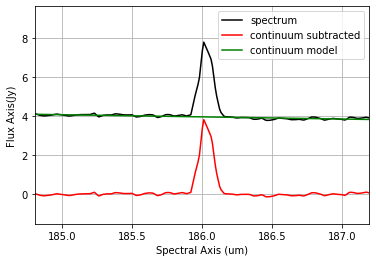

In [21]:
#4.B Use the local class 'LineFitterMult'
wline = wlines['CO14-13']
band = 'R1'

line = LineFitterMult(spectrum_cnt, wline, band, polyOrder=1, widthFactor=10, verbose=0)

print('Centre: {}, Peak: {}, FWHM: {}'.format(line.get_line_centre(), line.get_line_peak(), line.get_line_fwhm()))
plt.plot(spectrum_cnt.spectral_axis, spectrum_cnt.flux, label='spectrum', color='k')
plt.plot(spectrum_cnt.spectral_axis, line.get_line_spec().flux, label='continuum subtracted', color='r')  # with units
plt.plot(spectrum_cnt.spectral_axis, line.continuumModel(spectrum_cnt.spectral_axis.value), label='continuum model', color='g')
plt.xlim((line.get_wmin(), line.get_wmax()))
plt.xlabel('Spectral Axis ({})'.format(spectrum_cnt.spectral_axis.unit)) 
plt.ylabel('Flux Axis({})'.format(spectrum_cnt.flux.unit)) 
plt.grid(True) 
plt.legend()

In [22]:
#5. Cube extraction for cube fitting efficiency
# Extracting a cube spectral slab between two spectral coordinates
sc_slab = sc_um.spectral_slab(line.get_wmin() * u.um, line.get_wmax() * u.um)  
print(sc_slab)

SpectralCube with shape=(234, 24, 25) and unit=Jy:
 n_x:     25  type_x: RA---TAN  unit_x: deg    range:   293.340740 deg:  293.362018 deg
 n_y:     24  type_y: DEC--TAN  unit_y: deg    range:    19.938972 deg:   19.958140 deg
 n_s:    234  type_s: WAVE      unit_s: um     range:      184.800 um:     187.193 um


In [23]:
#6. Pixel by pixel cube fitting using the initialized model (only valid for the spectral region)
# This cell takes the compoundModel fitted to the central spaxel spectrum
model_init = line.get_line_model()            
print(model_init)

<QuantityModel CompoundModel(c0_0=24.56368156, c1_0=-0.11077251, amplitude_1=3.709409, mean_1=186.02895352, stddev_1=0.04797296), input_units=um, return_units=Jy>


In [24]:
# Decomposing the compoundModel prescription into: 1) model components in a list 
# and 2) the model arithmetic expression. The model prescription changes to do cube 
# fitting using backend     
component_list = model_init._leaflist
expression = model_init._format_expression()

names = model_init.submodel_names
n_submodels = model_init.n_submodels
for i in range(n_submodels):
    expression = expression.replace('[{}]'.format(i), names[i])

In [25]:
# Casting cube into a Spectrum1D to use the backend fitting generalized for a cube 
nan_mask = ~sc_slab.get_mask_array()
nan_mask = nan_mask.transpose(1, 2, 0)
flux_data = sc_slab.unmasked_data[:].value.transpose(1, 2, 0)

cube_spec = Spectrum1D(spectral_axis=sc_slab.spectral_axis, flux=flux_data * u.um, 
                       mask=nan_mask)

fitted_pars, fitted_spectrum = fit_model_to_spectrum(cube_spec, component_list,
                                                     expression, run_fitter=True)
# I/O: Outputs are a dictionary of 2D parameters and a 3D Spectrum1D

Enter callback
Enter callback
Enter callback
Enter callback
Enter callback
Enter callback
Enter callback


<!-- Returns
-------
:list: a list that stores 2D arrays. Each array contains one
    parameter from `astropy.modeling.CompoundModel` instances
    fitted to every spaxel in the input cube.
:class:`specutils.spectrum.Spectrum1D`
    The spectrum that stores the fitted model values in its 'flux'
    attribute.
-->    
cube_from_model taking advantage that the model parameters can be of any size, provided they are broadcastable (like numpy arrays)
It would be good to display the fitted model values in one of the cube uncert-viewer

In [26]:
# 7. Continuum model evaluation and subtraction
p_names = list(fitted_pars.keys())
nx, ny = fitted_pars[p_names[0]].shape
nl = sc_slab.spectral_axis.size
continuum_model = models.Polynomial1D(degree=1, c0=np.repeat(fitted_pars[p_names[0]].value[:,:,np.newaxis], nl, axis=2),
                                      c1=np.repeat(fitted_pars[p_names[1]].value[:,:,np.newaxis], nl, axis=2), name='cont_cube')
continuum_cube = continuum_model(sc_slab.spectral_axis.value) * u.Jy

# Back to the SpectralCube domain
sc_cont = SpectralCube(data=continuum_cube.transpose(2,0,1), wcs=sc_slab.wcs)
sc_fit = SpectralCube(data=fitted_spectrum.flux.value.transpose(2,0,1) * u.Jy, wcs=sc_slab.wcs)
sc_line = sc_slab - sc_cont

# Cube arithmetic to subtract continuum to original cube
sc_line = sc_slab - sc_cont
sc_line_model = sc_fit - sc_cont

In [27]:
# Visualize result in UI
app.add_data(sc_line, data_label='Line (cube - cont)')
app.add_data_to_viewer('mask-viewer', 'Line (cube - cont)')